# Ttianic Survivor Dataset

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline        import Pipeline

In [2]:
data_path = '../Data/Titanic/train.csv'

titanic = pd.read_csv(data_path, index_col = 0)

# Just in case I want to compare to the original
copy = titanic

titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Things to note.

* Age is not complete
* Cabin only has 200 datapoints
* Embarked is missing two datapoints
* Everything else is complete

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


For the survived column, 0 means the person died and 1 means they lived. As can be seen below, more people died than lived.

In [4]:
titanic['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

* Age is incomplete
* Mean age is around 30 with most being between 20 and 38
* Describe says someone paid 0 for ticket. Interesthing thing to check on
* 0.42 is a very weird description of age, most would put down 1 or 6 months. Why is this 0.42?

In [5]:
titanic[['Age', 'Fare']].describe()

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


Mostly men aboard the Titanic

In [6]:
titanic['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Ticket doesn't seem to be a useful column here. Doesn't seem to be standardized in a usable way.

In [7]:
titanic['Ticket'].value_counts()

1601                7
CA. 2343            7
347082              7
CA 2144             6
3101295             6
347088              6
S.O.C. 14879        5
382652              5
17421               4
19950               4
LINE                4
113781              4
349909              4
PC 17757            4
4133                4
347077              4
W./C. 6608          4
113760              4
2666                4
PC 17582            3
230080              3
PC 17572            3
345773              3
110413              3
13502               3
F.C.C. 13529        3
SC/Paris 2123       3
110152              3
371110              3
35273               3
                   ..
349234              1
349231              1
C.A./SOTON 34068    1
345774              1
C.A. 29178          1
C.A. 17248          1
349256              1
244373              1
113051              1
347074              1
11752               1
349239              1
A/5 3540            1
113509              1
3101296   

S = Southampton
C = Cherbourg
Q = Queenstown/Cobh

In [8]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Vast majority of passengers travelled alone.

Parch is describing the number of parents/children aboard the titanic.
SibSp is describing the number of siblings/spouses aboard.

In [9]:
titanic['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [10]:
titanic['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Things to note at this point.

* Age and Sex are very likely related to survival. 'Women and Children first.'
* Age isn't complete so something ust be done there
* Ticket seems completely useless
* Cabin isn't complete nor does it seem useful anyway
* Name isn't important but can extract title from Name, could be useful
* Look into maybe changing Age and Fare into a range rather than just a number. Check with and without to see if it helps

In [11]:
titanic[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [12]:
titanic[['Pclass', 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


There does seem to be some correlation between survival and where a passenger embarked. At the very least for passengers from Cherbourg.

In [13]:
titanic[['Embarked', 'Survived']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


Investigation on survival and age groups.

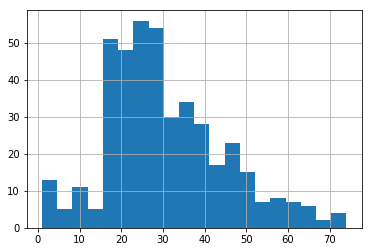

In [14]:
dead = titanic[titanic['Survived'] == 0]
dead['Age'].hist(bins = 20);

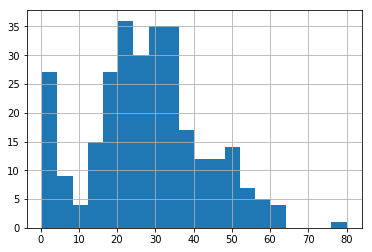

In [15]:
alive = titanic[titanic['Survived'] == 1]
alive['Age'].hist(bins = 20);

## Dropping Some Features

Some features just don't have any relevance from the investigation. Ticket and Cabin do not seem relevant because either there is no real corellation I can think of or because the data is incomplete. I am just going to get rid of them.

In [16]:
class DropUselessTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return X.drop(['Ticket', 'Cabin'], axis = 1)

In [17]:
print(titanic.shape)
drop = DropUselessTransformer()
titanic = drop.transform(titanic)
print(titanic.shape)

(891, 11)
(891, 9)


## Feature Creation

At this point, I think it would be worthwhile trying to create an age band feature as well as investigating the possibility of creating a Title feature.

### Age Band

Here I split age into various age bands and check to see if it works out. Each age band is a gap of 10 years.

I should fill in the missing values before doing this however.

In [18]:
class AgeBandTransformer(BaseEstimator, TransformerMixin):
    '''
    Custom transformer class that will be used to convert
    the Age column into a more useful AgeBand column.
    
    Takes in one argument to decide on what the resulting
    column will be named. Should be noted that naming it Age will
    overwrite the column that is already there.
    '''
    def __init__(self, age_band_column_name = 'AgeBand'):
        self.column_name = age_band_column_name
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        # There are missing values in the Age column
        # The first two lines of code are simply to get fill  missing values by
        # the meddian of Sex and Class grouped
        new_age = X.groupby(['Sex', 'Pclass']).Age.apply(lambda x: x.fillna(x.median()))
        X['Age'] = new_age.values
        
        bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
        labels = [0, 1, 2, 3, 4, 5, 6, 7]
        
        X[self.column_name] = pd.cut(X['Age'], bins = bins, labels = labels)
        
        return X

In [19]:
age_attr = AgeBandTransformer()
titanic = age_attr.transform(titanic)

titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,3


In [20]:
titanic[['AgeBand', 'Survived']].groupby('AgeBand').mean()

,Survived
AgeBand,
0,0.593750
1,0.382609
2,0.323607
3,0.448649
4,0.383721
5,0.404762
6,0.235294
7,0.200000


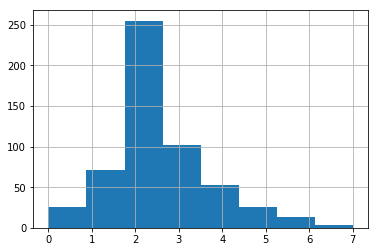

In [21]:
dead = titanic[titanic['Survived'] == 0]
dead['AgeBand'].hist(bins = 8);

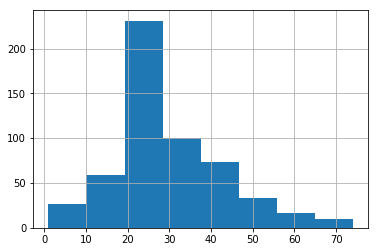

In [22]:
dead['Age'].hist(bins = 8);

In [23]:
titanic[titanic['Age'] > 70]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
PassengerId,,,,,,,,,,
97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,34.6542,C,7
117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,7.7500,Q,7
494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,49.5042,C,7
631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,30.0000,S,7
852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,7.7750,S,7


In [24]:
titanic[(titanic['Age'] > 60) & (titanic['Age'] < 70)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
PassengerId,,,,,,,,,,
34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,10.5000,S,6
55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,61.9792,C,6
171,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,33.5000,S,6
253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,26.5500,S,6
276,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0,1,0,77.9583,S,6
281,0,3,"Duane, Mr. Frank",male,65.0,0,0,7.7500,Q,6
327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,6.2375,S,6
439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,263.0000,S,6
457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,26.5500,S,6


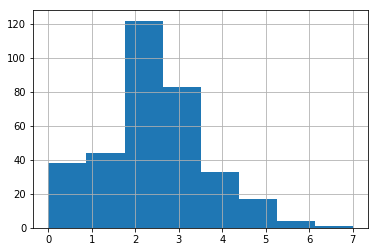

In [25]:
alive = titanic[titanic['Survived'] == 1]
alive['AgeBand'].hist(bins = 8);

### Encoding Gender

Encode the Sex attribute

In [26]:
class ColumnEncoder(BaseEstimator, TransformerMixin):
    '''
    This encoder is basically LabelEncoder but I want to do
    it for multiple columns in the dataframe at once.
    '''
    
    def __init__(self, column_names = ['Sex', 'Embarked']):
        self.column_names = column_names
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        for column in self.column_names:
            encoded, key = X[column].factorize()
            X[column] = encoded
            
        return X

In [27]:
class SexEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_name = 'Sex'):
        self.column_name = column_name
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        encoded, sex = X['Sex'].factorize()
        # print(sex)
        X[self.column_name] = encoded
        
        return X

In [28]:
sex_encoder = SexEncoder()
titanic = sex_encoder.transform(titanic)

In [29]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,3
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,3
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,3


### Fare Range

Change Fare into a range rather than a single number

describe and hist both show the same thing. All fares are centered around the 32 price range and the vast majority don't go above 100.

In [30]:
titanic['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

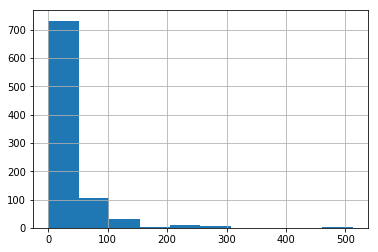

In [31]:
titanic['Fare'].hist();

There are no ticket prices within the 300 to 460 range. I'm keeping those bands however since this dataset is only of 891 people. There may be some who paid in that range.

The FareLabels column is purely to show what values fall under what label. I don't actually do anything with this.

In [32]:
titanic['FareLabels'] = pd.cut(titanic['Fare'], bins = 10)
titanic[['FareLabels', 'Survived']].groupby('FareLabels').mean()

,Survived
FareLabels,
"(-0.512, 51.233]",0.318306
"(51.233, 102.466]",0.660377
"(102.466, 153.699]",0.741935
"(153.699, 204.932]",1.000000
"(204.932, 256.165]",0.636364
"(256.165, 307.398]",0.666667
"(307.398, 358.63]",NaN
"(358.63, 409.863]",NaN
"(409.863, 461.096]",NaN


In [33]:
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
titanic['FareRange'] = pd.cut(titanic['Fare'], bins = 10, labels = labels)
titanic[['FareRange', 'Survived']].groupby('FareRange').mean()

,Survived
FareRange,
0,0.318306
1,0.660377
2,0.741935
3,1.000000
4,0.636364
5,0.666667
6,NaN
7,NaN
8,NaN


In [34]:
class FareRangeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name = 'FareRange'):
        self.column_name = column_name
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        
        X[self.column_name] = pd.cut(X['Fare'], bins = 10, labels = labels)
        return X

In [35]:
fare = FareRangeTransformer('Fare')
titanic = fare.transform(titanic)

titanic = titanic.drop(['FareLabels', 'FareRange'], axis = 1)
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,0,S,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,1,C,3
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,0,S,2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,1,S,3
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,0,S,3


### Encode Embarked

In [36]:
class EmbarkTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name = 'Embarked'):
        self.column_name = column_name
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        encoded, embarked = X['Embarked'].factorize()
        # print(embarked)
        X['Embarked'] = encoded
        
        return X

em_transformer = EmbarkTransformer()
titanic = em_transformer.transform(titanic)
    
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,0,0,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,1,1,3
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,0,0,2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,1,0,3
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,0,0,3


### Extract Title and Compare Model

I'm assuming that people who have unique titles are somewhat unique people and usually of upper class.

In [37]:
class TitleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name = 'Title', enable_in_pipeline = True, retain_name = False):
        '''
        enable_in_pipeline is solely for when I put this transformer into
        a pipeline. I want to be able to toggle whether this transformer
        is used or not in a gridsearchCV.
        '''
        self.column_name = column_name
        self.pipeline = enable_in_pipeline
        self.retain_name = retain_name
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        if self.pipeline:
            X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)

            X['Title'] = X['Title'].replace(['Dr', 'Rev', 'Major',
                                                 'Col', 'Lady', 'Capt',
                                                 'Countess', 'Sir', 'Don',
                                                 'Jonkheer'], 'Upper')
            X['Title'] = X['Title'].replace('Ms', 'Miss')
            X['Title'] = X['Title'].replace('Mlle', 'Miss')
            X['Title'] = X['Title'].replace('Mme', 'Mrs')

            encoded, title = X['Title'].factorize()
            # print(title)
            X['Title'] = encoded
        
        if not self.retain_name: 
            X = X.drop('Name', axis = 1)

        return X

In [38]:
title_encoder = TitleTransformer(retain_name = True)
titanic = title_encoder.transform(titanic)

In [39]:
titanic['Title'].value_counts()

0    517
2    185
1    126
3     40
4     23
Name: Title, dtype: int64

The following seems to prove what I said. People in Upper are generally the higher class passengers. There is an exception, however, for Mr. There are still many more lower class Mr than upper class Mr.

In [40]:
titanic.groupby(['Title', 'Pclass']).size()

Title  Pclass
0      1         107
       2          91
       3         319
1      1          43
       2          41
       3          42
2      1          48
       2          35
       3         102
3      1           3
       2           9
       3          28
4      1          15
       2           8
dtype: int64

Looking at the title's survival rate, it seems to show that Women survived more. Miss and Mrs had survival rates of 70% and 80% respectively. Male children seemed to survive more as well at 57%.

Curiously, Upper has a fairly low survival rate. Will investigate more.

In [41]:
titanic[['Title', 'Survived']].groupby('Title').mean()

,Survived
Title,
0,0.156673
1,0.793651
2,0.702703
3,0.575000
4,0.347826


Looking at these results, it seems that the Female nobility mostly survived.

After that, I seemed to have mistaken staff members, Reverends and soldiers for a higher class. It seems most of these people are the ones who died and brought down Upper's survival rate.

I don't know if I can really improve this though. Maybe rename the column to Unique instead?

In [42]:
titanic[['Title', 'Name', 'Survived']][titanic['Title'] == 4].sort_values(by = ['Survived'])

,Title,Name,Survived
PassengerId,,,
31,4,"Uruchurtu, Don. Manuel E",0
823,4,"Reuchlin, Jonkheer. John George",0
767,4,"Brewe, Dr. Arthur Jackson",0
746,4,"Crosby, Capt. Edward Gifford",0
695,4,"Weir, Col. John",0
849,4,"Harper, Rev. John",0
537,4,"Butt, Major. Archibald Willingham",0
627,4,"Kirkland, Rev. Charles Leonard",0
399,4,"Pain, Dr. Alfred",0


At this point, all that is left is to encode the Title column and drop the Name column.

In [43]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand,Title
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,0,0,2,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,1,1,3,1
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,0,0,2,2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,1,0,3,1
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,0,0,3,0


### Comparison

Just for the purposes to see how far the dataframe has changed, I will just show the original as taken from the csv file and then everything changed up until this point.

In [44]:
copy.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
titanic.drop(['Name', 'Age'], axis = 1).head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeBand,Title
PassengerId,,,,,,,,,
1,0,3,0,1,0,0,0,2,0
2,1,1,1,1,0,1,1,3,1
3,1,3,1,0,0,0,0,2,2
4,1,1,1,1,0,1,0,3,1
5,0,3,0,0,0,0,0,3,0


## Creating a Model

In [46]:
# First I want to reset the dataframe back to it's original form
titanic = copy

For the moment, I will ignore the Name column. Extracting Title from a name isn't extremely easy right at the moment but I am still curious to see if Title will do anything anyway. Title for the most part will be able to be taken from gender, age and even class. For example, it isn't a stretch that a 1st class, female passenger is the countess. So, for the moment, I will just drop Name and see what kind of value creating a model gets me for now.

In [47]:
X = titanic.drop('Survived', axis = 1)
y = titanic['Survived']

In [48]:
transform_pipeline = Pipeline([('Drop',   DropUselessTransformer()),
                               ('Encoder', ColumnEncoder()),
                               ('Age',    AgeBandTransformer('Age')),
                               ('Fare',   FareRangeTransformer('Fare')),
                               ('Title',  TitleTransformer())])

X = transform_pipeline.transform(X)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,2,1,0,0,0,0
2,1,1,3,1,0,1,1,1
3,3,1,2,0,0,0,0,2
4,1,1,3,1,0,1,0,1
5,3,0,3,0,0,0,0,0


### Split into test and training sets

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.1,
                                                    random_state = 7)

### Logistic Regression

I will begin with one of the easiest models first.

In [50]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Logistic Regression Accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred) * 100))

Logistic Regression Accuracy: 80.00%


In [51]:
X = titanic.drop('Survived', axis = 1)
y = titanic['Survived']

param_grid = {'Title__enable_in_pipeline' : [True, False],
              'logreg__penalty' : ['l1', 'l2'],
              'logreg__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

full_pipeline = Pipeline([('Drop',   DropUselessTransformer()),
                          ('Encoder', ColumnEncoder()),
                          ('Age',    AgeBandTransformer('Age')),
                          ('Fare',   FareRangeTransformer('Fare')),
                          ('Title',  TitleTransformer()),
                          ('logreg', LogisticRegression())])

grid_search = GridSearchCV(full_pipeline, param_grid = param_grid, return_train_score = True)
grid_search.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('Drop', DropUselessTransformer()), ('Encoder', ColumnEncoder(column_names=['Sex', 'Embarked'])), ('Age', AgeBandTransformer(age_band_column_name=None)), ('Fare', FareRangeTransformer(column_name='Fare')), ('Title', TitleTransformer(column_name='Title', enable_in_pipeline=None,
         retai...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'Title__enable_in_pipeline': [True, False], 'logreg__penalty': ['l1', 'l2'], 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [52]:
grid_search.best_params_, grid_search.best_score_

({'Title__enable_in_pipeline': True, 'logreg__C': 10, 'logreg__penalty': 'l1'},
 0.80471380471380471)

In [53]:
grid_search.cv_results_

{'mean_fit_time': array([ 0.00997337,  0.01196178,  0.01230224,  0.01030564,  0.0083197 ,
         0.00997249,  0.01694457,  0.01032106,  0.01663105,  0.0089558 ,
         0.01663963,  0.01028919,  0.01694417,  0.00997297,  0.00964363,
         0.01196822,  0.01030556,  0.00798806,  0.00898488,  0.00897813,
         0.01264079,  0.00932797,  0.015294  ,  0.00929856,  0.01629837,
         0.0096515 ,  0.01595632,  0.00997329]),
 'mean_score_time': array([ 0.00831111,  0.0099748 ,  0.00830921,  0.00897582,  0.00664004,
         0.00831779,  0.00896819,  0.00797685,  0.00730666,  0.00731349,
         0.00829323,  0.00766277,  0.00698137,  0.00797892,  0.00763369,
         0.00864426,  0.00664926,  0.00698121,  0.00729068,  0.00698288,
         0.00698201,  0.00697184,  0.00731357,  0.0066572 ,  0.00631769,
         0.00696429,  0.00733256,  0.00697184]),
 'mean_test_score': array([ 0.61616162,  0.62065095,  0.61616162,  0.7295174 ,  0.78675645,
         0.80022447,  0.7979798 ,  0.7957351

In [54]:
from sklearn.neighbors import KNeighborsClassifier

X = titanic.drop('Survived', axis = 1)
y = titanic['Survived']

param_grid = {'Title__enable_in_pipeline' : [True, False],
              'knn__weights' : ['uniform', 'distance']}

full_pipeline = Pipeline([('Drop',   DropUselessTransformer()),
                               ('Age',    AgeBandTransformer('Age')),
                               ('Sex',    SexEncoder()),
                               ('Fare',   FareRangeTransformer('Fare')),
                               ('Embark', EmbarkTransformer()),
                               ('Title',  TitleTransformer()),
                               ('knn',    KNeighborsClassifier(5))])

grid_search = GridSearchCV(full_pipeline, param_grid = param_grid, return_train_score = True)
grid_search.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('Drop', DropUselessTransformer()), ('Age', AgeBandTransformer(age_band_column_name=None)), ('Sex', SexEncoder(column_name='Sex')), ('Fare', FareRangeTransformer(column_name='Fare')), ('Embark', EmbarkTransformer(column_name='Embarked')), ('Title', TitleTransformer(column_name='Title', enable...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'Title__enable_in_pipeline': [True, False], 'knn__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [55]:
grid_search.best_params_, grid_search.best_score_

({'Title__enable_in_pipeline': True, 'knn__weights': 'uniform'},
 0.7485970819304153)

In [56]:
grid_search.cv_results_

{'mean_fit_time': array([ 0.01394137,  0.00864339,  0.00831103,  0.00797852]),
 'mean_score_time': array([ 0.01163443,  0.00797868,  0.00831095,  0.0086449 ]),
 'mean_test_score': array([ 0.74859708,  0.74186308,  0.74859708,  0.74186308]),
 'mean_train_score': array([ 0.8338945 ,  0.94893378,  0.8338945 ,  0.94893378]),
 'param_Title__enable_in_pipeline': masked_array(data = [True True False False],
              mask = [False False False False],
        fill_value = ?),
 'param_knn__weights': masked_array(data = ['uniform' 'distance' 'uniform' 'distance'],
              mask = [False False False False],
        fill_value = ?),
 'params': [{'Title__enable_in_pipeline': True, 'knn__weights': 'uniform'},
  {'Title__enable_in_pipeline': True, 'knn__weights': 'distance'},
  {'Title__enable_in_pipeline': False, 'knn__weights': 'uniform'},
  {'Title__enable_in_pipeline': False, 'knn__weights': 'distance'}],
 'rank_test_score': array([1, 3, 1, 3]),
 'split0_test_score': array([ 0.71380471, 

In [57]:
titanic = copy
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [61]:
titanic = copy
X = titanic.drop('Survived', axis = 1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.1,
                                                    random_state = 7)

transform_pipeline = Pipeline([('Drop',   DropUselessTransformer()),
                               ('Encoder', ColumnEncoder()),
                               ('Age',    AgeBandTransformer('Age')),
                               ('Fare',   FareRangeTransformer('Fare')),
                               ('Title',  TitleTransformer())])

X = transform_pipeline.transform(X_train)
x_test = transform_pipeline.transform(X_test)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
889,3,0,2,1,2,0,0,0
450,1,1,5,0,0,0,0,1
854,1,0,1,0,1,0,0,0
853,3,0,0,1,1,0,1,0
389,3,1,2,0,0,0,2,2


In [63]:
import lightgbm as lgb

d_train = lgb.Dataset(X, label = y_train)

In [64]:
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

clf = lgb.train(params, d_train, 100)

In [66]:
y_pred = clf.predict(x_test)

for i in range(0, len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

In [67]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_pred, y_test)

Yikes!

Just wanted to try out the lightgbm classi

In [68]:
accuracy

0.26666666666666666